In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv
import re
from lxml import etree
from datetime import date,datetime
import pandas as pd
import math
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest = html.xpath('.//td[@id="cpn_desc"]/text()')
    pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    interest = pattern.findall(interest[0])
    
    if(len(interest) == 1):
        interest = interest*years
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if('db' not in category):
                continue
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(db_df,db_buy_dict,file,show_price=False):
    total_number = len(db_df)
    quartile = np.percentile(db_df['premium'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in db_df.index:
                print("Strong sell %s %s for not in the low premium list"%(cb_id,cb_name))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            premium = db_df.loc[cb_id]['premium']
            fit_price = db_df.loc[cb_id]['fit_price']
            low_fit_price = db_df.loc[cb_id]['low_fit_price']
            upper_fit_price = db_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'premium':premium}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                if('db' in category and price<fit_price):
                    continue
                sell = "Sell"
                if(premium>quartile or price>upper_fit_price):
                    if('db' in category and price<upper_fit_price):
                        continue
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,premium))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        premium = db_df.loc[cb_id]['premium']
        low_fit_price = db_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,premium))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = db_df.loc[cb_id]['price']
        premium = db_df.loc[cb_id]['premium']
        low_fit_price = db_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f"%(cb_id,cb_name,price,premium))
        if cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,premium))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat(get_force_redeem="No"):
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['force_redeem']
        is_list = dat_cell['price_tips']
        
            
        
        force_redeem_boolean = False
        if(get_force_redeem=="No"):
            if(is_force_redeem == None or '不行使' in is_force_redeem ):
                force_redeem_boolean = True
            else:
                force_redeem_boolean = False
        else:
            if(is_force_redeem == None):
                force_redeem_boolean = False
            else:
                force_redeem_boolean = True
        
        if force_redeem_boolean and is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            if(get_force_redeem == "No"):
                lst_dat['next_put_dt'] = next_put_dt
                lst_dat['put_price'] = put_price
                lst_dat['put_convert_price'] = put_convert_price
            
                lst_dat['maturity_dt'] = maturity_dt
                lst_dat['redeem_price'] = redeem_price
                lst_dat['last_time'] = last_time
                lst_dat['force_redeem'] = is_force_redeem
            
            else:
                lst_dat['redeem_dt']  = redeem_dt
                lst_dat['force_redeem_price'] = force_redeem_price
                lst_dat['force_redeem'] = is_force_redeem
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            

        
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        #convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        convert_value = item['convert_value']
        
            
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        convert_value = float(convert_value)
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    x = []
    y = []
    ids = []
    names = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    xext = np.linspace(convert_value_limit,max(x))
    yext = xext+price_limit-convert_value_limit

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        

        premium = (price/value-1)*100
        
        if(price<price_limit):
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=5)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('premium')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# plot history

In [31]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [32]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
#force_redeem_data = get_dat('Yes')
#pd.DataFrame.from_dict(force_redeem_data).to_csv(r'CB_force_redeem_list.csv',index=False)

processing 100 items
processing 200 items
processing 300 items
Finished processing 369 items


In [33]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 385 lines.


In [34]:
redeem_df = redeem_arbitrage(data)

In [35]:
put_df = put_arbitrage(data)

Finished processing 46 items


Strong Sell 128100 搜特转债 96.72 210.389

Add  132018 G三峡EB1 120.65 127.227
Add  110033 国贸转债 117.1 131.033
Add  113610 灵康转债 125.55 132.844
Add  110070 凌钢转债 125.02 134.001
Add  128087 孚日转债 102.687 134.256
Add  113607 伟20转债 129.2 137.424
Add  113009 广汽转债 123.21 137.473

Buy  113030 东风转债 113.25 139.185
Buy  113541 荣晟转债 123.99 139.301
Buy  123106 正丹转债 128.38 139.401
Buy  128081 海亮转债 121.0 141.621
today coef [3.08369446e-03 4.74389676e-02 9.19265240e+01]
mse=57.752


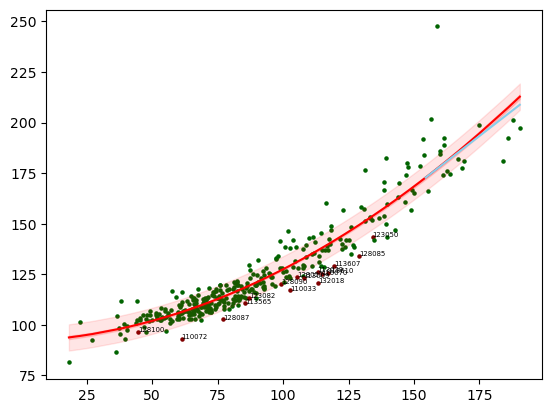

In [36]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [37]:
#Every Friday sell cb in the sell list
#If db value higher than 25 percentile, also sell them in the other working day

In [38]:
my_df

,name,price,db_low
id,,,
132018,G三峡EB1,120.650,127.226560
110033,国贸转债,117.100,131.033429
113610,灵康转债,125.550,132.843876
110070,凌钢转债,125.020,134.001425
128087,孚日转债,102.687,134.256139
113607,伟20转债,129.200,137.423803
113009,广汽转债,123.210,137.473285
113039,嘉泽转债,126.170,137.629833
128085,鸿达转债,134.120,138.197600


In [39]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

No CB to sell

Add  123102 华自转债 181.07 -1.601
Add  113012 骆驼转债 143.65 2.792
Add  113585 寿仙转债 146.7 2.793
Add  128103 同德转债 192.15 3.294
Add  113621 彤程转债 197.36 3.637
Add  128085 鸿达转债 134.12 4.078

Buy  123102 华自转债 181.07 -1.601
Buy  113012 骆驼转债 143.65 2.792
Buy  113585 寿仙转债 146.7 2.793
Buy  128103 同德转债 192.15 3.294
Buy  113621 彤程转债 197.36 3.637
Strong Buy 128085 鸿达转债 134.12 4.078
Buy  120004 20华菱EB 157.0 5.437
Buy  132014 18中化EB 142.0 5.445
Buy  128050 钧达转债 177.764 5.562
Buy  120003 19华菱EB 174.47 6.455
Strong Buy 132018 G三峡EB1 120.65 6.577
Buy  128128 齐翔转2 166.074 6.775
Buy  123087 明电转债 135.16 7.171


In [40]:
my_df

,name,price,db_low
id,,,
132018,G三峡EB1,120.650,127.226560
110033,国贸转债,117.100,131.033429
113610,灵康转债,125.550,132.843876
110070,凌钢转债,125.020,134.001425
128087,孚日转债,102.687,134.256139
113607,伟20转债,129.200,137.423803
113009,广汽转债,123.210,137.473285
113039,嘉泽转债,126.170,137.629833
128085,鸿达转债,134.120,138.197600


today quartile 155.25686415133566


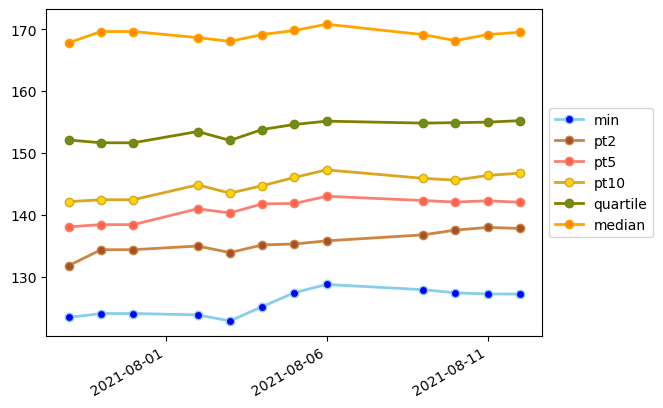

In [41]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 22.83961112911984


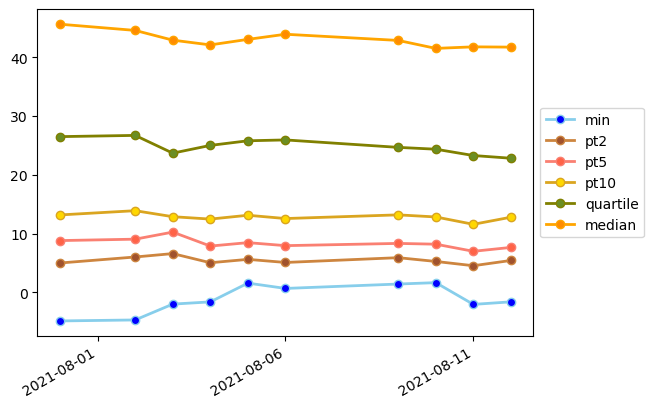

In [42]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

In [43]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
132018,G三峡EB1,600900.ss,长江电力,120.650,117.62,2.72%,AAA,2.56,3.9%,3.9%,...,11.72,2024-04-09,108.000,2.660,None,0.000000,0.0,113.205005,0.065766,127.226560
110033,国贸转债,600755.ss,厦门国贸,117.100,111.31,5.20%,AAA,0.57,8.3%,7.9%,...,4.70,2022-01-05,108.000,0.400,None,0.000000,0.0,102.779317,0.139334,131.033429
113610,灵康转债,603669.ss,灵康药业,125.550,124.27,1.03%,AA-,5.04,6.2%,6.2%,...,6.03,2026-11-30,115.000,5.304,None,0.000000,0.0,117.015066,0.072939,132.843876
110070,凌钢转债,600231.ss,凌钢股份,125.020,117.47,6.43%,AA,1.04,2.4%,2.4%,...,1.88,2026-04-12,112.000,4.668,None,0.000000,0.0,114.716797,0.089814,134.001425
128087,孚日转债,002083.sz,孚日股份,102.687,90.44,13.54%,AA-,1.00,17.6%,17.6%,...,3.15,2025-12-17,108.000,4.351,None,0.019558,0.0,76.904762,0.335249,134.256139
113607,伟20转债,603568.ss,伟明环保,129.200,123.68,4.47%,AA,5.92,3.6%,3.6%,...,15.20,2026-11-01,110.000,5.225,None,0.000000,0.0,119.382239,0.082238,137.423803
113009,广汽转债,601238.ss,广汽集团,123.210,110.31,11.70%,AAA,1.84,2.3%,1.6%,...,9.78,2022-01-22,106.000,0.447,None,0.000000,0.0,107.829912,0.142633,137.473285
113039,嘉泽转债,601619.ss,嘉泽新能,126.170,119.65,5.45%,AA,2.56,5.7%,5.5%,...,2.42,2026-08-23,108.000,5.033,None,0.000000,0.0,113.197729,0.114598,137.629833
128085,鸿达转债,002002.sz,鸿达兴业,134.120,134.02,0.08%,B,1.82,4.0%,4.0%,...,2.74,2025-12-16,118.000,4.348,None,0.000000,0.0,128.865385,0.040776,138.197600


In [44]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
113030,东风转债,601515.ss,东风股份,113.25,92.87,21.95%,AA,1.71,3.7%,3.7%,...,4.51,2025-12-23,112.000,4.367,None,0.005217,0.000000,89.556413,0.264566,139.184938
113541,荣晟转债,603165.ss,荣晟环保,123.99,113.01,9.72%,AA-,1.85,5.1%,5.1%,...,7.59,2025-07-22,110.000,3.945,None,0.000000,0.000000,107.526166,0.153115,139.301468
123106,正丹转债,300641.sz,正丹股份,128.38,123.73,3.76%,AA-,3.07,7.0%,7.0%,...,5.25,2027-03-23,120.000,5.614,None,0.000000,0.000000,115.635514,0.110213,139.401256
110072,广汇转债,600297.ss,广汇汽车,92.97,70.22,32.39%,AA+,0.56,14.7%,14.7%,...,2.82,2026-08-17,110.000,5.016,None,0.041095,0.030614,61.220575,0.518607,140.721255
128090,汽模转2,002510.sz,天汽模,120.29,106.62,12.82%,AA-,2.03,7.4%,7.3%,...,2.96,2025-12-27,110.000,4.378,None,0.000000,0.000000,99.273743,0.211700,141.460006
128057,博彦转债,002649.sz,博彦科技,123.80,116.35,6.40%,AA-,1.69,10.6%,9.4%,...,5.95,2025-03-05,112.000,3.564,None,0.000000,0.000000,105.198915,0.176818,141.481822
128081,海亮转债,002203.sz,海亮股份,121.00,114.86,5.35%,AA,2.16,14.5%,13.7%,...,6.78,2025-11-21,110.000,4.279,None,0.000000,0.000000,100.314410,0.206208,141.620756
123082,北陆转债,300016.sz,北陆药业,113.20,99.32,13.98%,A+,2.40,14.0%,11.6%,...,6.17,2026-12-06,115.000,5.321,None,0.012137,0.000000,87.122807,0.299315,141.917866
113577,春秋转债,603890.ss,春秋电子,129.07,118.42,9.00%,AA-,2.59,3.6%,3.5%,...,7.60,2026-04-13,112.000,4.671,2021年4月7日公告，本次（2021年2月22日至2021年4月2日）不行使春秋转债提前赎...,0.000000,0.000000,114.305019,0.129172,141.987176


In [45]:
lp_df[0:20]

,name,value,price,premium,fit_price,low_fit_price,upper_fit_price
id,,,,,,,
123102,华自转债,184.015817,181.070,-1.600850,202.380212,195.871801,208.888623
113012,骆驼转债,139.748062,143.650,2.792123,158.779103,152.325068,165.233139
113585,寿仙转债,142.713864,146.700,2.793096,161.503089,155.046438,167.959741
128103,同德转债,186.023166,192.150,3.293587,204.387561,197.875912,210.899210
113621,彤程转债,190.433498,197.360,3.637229,208.797892,202.278896,215.316889
128085,鸿达转债,128.865385,134.120,4.077600,149.248481,142.802769,155.694193
120004,20华菱EB,148.904364,157.000,5.436802,167.363638,160.901049,173.826228
132014,18中化EB,134.667932,142.000,5.444554,154.239224,147.789323,160.689125
128050,钧达转债,168.397313,177.764,5.562255,186.761708,180.276217,193.247199


In [46]:
a = 'db_low'
b = db_df[a]
b.min()
np.percentile(db_df['db_low'],5)
np.percentile(b,5)

142.06756179232846

In [47]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,fit_price,low_fit_price,upper_fit_price
id,,,,,,,
113596,城地转债,27.127273,92.680,241.648794,95.482670,89.017246,101.948095
128062,亚药转债,18.165200,81.428,348.263720,93.805803,87.330227,100.281379
132011,17浙报EB,22.525570,101.200,349.267202,94.559784,88.089316,101.030253


In [48]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,next_put_dt,put_price,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,81.428,26.83,203.49%,BB,3.67,47.7%,41.2%,2023-04-03,100.000,11.38,2025-04-02,115.000,3.641,None,102.00,0.137770,1.745205
113595,花王转债,603007.ss,ST花王,86.550,47.11,83.72%,A,0.94,30.4%,30.1%,2024-07-22,100.000,4.84,2026-07-20,116.000,4.940,None,102.64,0.057509,3.049315
113017,吉视转债,601929.ss,吉视传媒,99.070,60.00,65.12%,AA+,0.79,28.3%,28.3%,2021-12-27,100.000,2.06,2023-12-27,106.000,2.375,None,101.04,0.041922,0.479452
128044,岭南转债,002717.sz,岭南股份,97.699,48.73,100.49%,AA-,0.98,20.3%,15.0%,2022-08-14,100.000,4.14,2024-08-14,107.000,3.008,None,102.00,0.039590,1.109589
113576,起步转债,603557.ss,ST起步,93.000,44.27,110.10%,A,1.43,11.5%,11.5%,2024-04-09,100.000,7.38,2026-04-09,115.000,4.660,2020年11月6日公告，本次（2020年10月16日至2020年11月5日）不行使起步转债...,103.04,0.037781,2.764384
113596,城地转债,603887.ss,城地香江,92.680,37.30,148.44%,AA-,0.99,37.5%,29.4%,2024-07-29,100.000,16.98,2026-07-27,108.000,4.959,None,102.48,0.033300,3.068493
110072,广汇转债,600297.ss,广汇汽车,92.970,70.22,32.39%,AA+,0.56,14.7%,14.7%,2024-08-19,100.000,2.82,2026-08-17,110.000,5.016,None,102.16,0.030614,3.126027
113589,天创转债,603608.ss,天创时尚,95.490,46.95,103.39%,AA,1.43,24.2%,24.2%,2024-06-24,100.000,8.60,2026-06-23,110.000,4.866,None,102.48,0.024050,2.972603
128100,搜特转债,002503.sz,搜于特,96.720,53.45,80.96%,A,1.38,20.3%,16.7%,2024-03-11,100.000,2.03,2026-03-11,112.000,4.581,None,102.48,0.021779,2.684932
